In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Optimising AWS Lambdas with CausaDB

In this notebook we'll demonstrate how to use CausaDB to optimise AWS Lambda functions. We already have historical data on workloads and performance, but this is confounded by the fact that anticipated workloads will have dictated the initial configuration of the functions. We'll use CausaDB to model causal relationships between these variables and identify the optimal configuration (`memory_size`) for our functions.

## Setup

Load the necessary libraries and data and provide CausaDB token.

In [100]:
from causadb import CausaDB
from causadb.plotting import plot_causal_graph, plot_causal_attributions
import os
import numpy as np
import pandas as pd

client = CausaDB(token=os.getenv("CAUSADB_TOKEN"))

## Load data

Load data from a CSV file and display the first few rows.

In [115]:
df = pd.read_csv('data/lambda_data.csv')
df.head()

,lambda_name,workload,memory_size,billed_duration,memory_used,cost,cost_per_million
0,LGP,228083,256,5424.0,41.0,0.000023,22.60452
1,ONW,1345432,6144,9277.0,52.0,0.000928,927.88554
2,LZD,532240,1024,5046.0,44.0,0.000084,84.11682
3,GGN,588079,128,30000.0,41.0,0.000063,62.51250
4,EDU,1614122,8192,12516.0,54.0,0.001669,1669.13376


## Attach data

Attach the data to CausaDB from the pandas DataFrame. This uploads the data to CausaDB and makes it available for model training.

In [102]:
client \
  .add_data("hnr-data") \
  .from_pandas(df)

## Define and train model

The next step is to create a model, specify its nodes (variables) and edges (causal relationships) and train it on the data.

In [103]:
model = client.create_model("hnr-model")
model.set_nodes(["workload", "memory_size", "memory_used", "billed_duration", "cost_per_million"])
model.set_edges([
    ("workload", "memory_size"),
    ("workload", "memory_used"),
    ("memory_size", "memory_used"),
    ("memory_size", "billed_duration"),
    ("workload", "billed_duration"),
    ("memory_used", "billed_duration"),
    ("memory_size", "cost_per_million"),
    ("billed_duration", "cost_per_million")
])

model.train("hnr-data")

The graph can be plotted to visualise the relationships between the variables using the `plot_causal_graph` method.

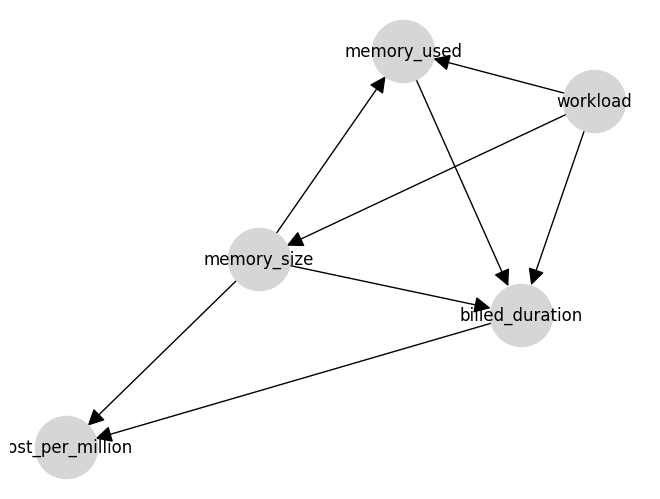

In [104]:
plot_causal_graph(model)

## Generating recommendations

The overall goal is to find the optimal `memory_size` for our Lambda functions. We can use the `find_best_actions` method to generate recommendations where `memory_size` is the actionable variable and the target is to minimise both `cost_per_million` and `billed_duration`.

In [116]:
recommendations = model.find_best_actions(
    targets={
        "cost_per_million": "minimise", 
        "billed_duration": "minimise"
    }, 
    actionable=["memory_size"],
    data=df
)

# Add the recommendations to the original data frame
df["memory_size_recommended"] = recommendations["memory_size"].apply(lambda x: round(x/64)*64).values
df.head()

,lambda_name,workload,memory_size,billed_duration,memory_used,cost,cost_per_million,memory_size_recommended
0,LGP,228083,256,5424.0,41.0,0.000023,22.60452,2816
1,ONW,1345432,6144,9277.0,52.0,0.000928,927.88554,1664
2,LZD,532240,1024,5046.0,44.0,0.000084,84.11682,2816
3,GGN,588079,128,30000.0,41.0,0.000063,62.51250,2560
4,EDU,1614122,8192,12516.0,54.0,0.001669,1669.13376,1600


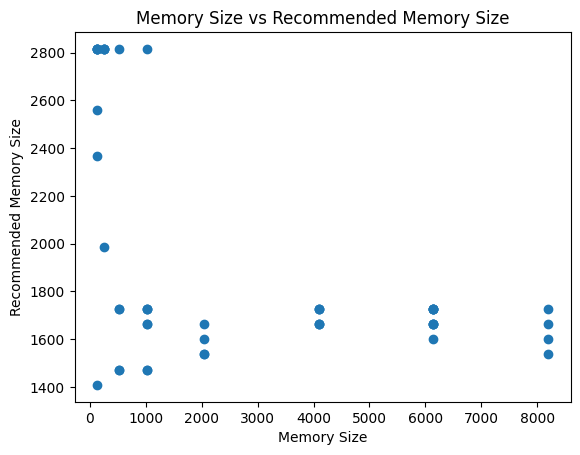

In [117]:
import matplotlib.pyplot as plt

# Plot memory size against memory size recommended
plt.scatter(df["memory_size"], df["memory_size_recommended"])
plt.xlabel("Memory Size")
plt.ylabel("Recommended Memory Size")
plt.title("Memory Size vs Recommended Memory Size")
plt.show()